In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# This project aims on converting one domain 256x256 RGB image to the other domain 256x256 RGB image.

# reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#            https://github.com/aladdinpersson/Machine-Learning-Collection
#            https://github.com/yunjey/pytorch-tutorial


# read data from img256
# One way is to read throughout ImageFolder

"""
import torch
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from PIL import Image

image_size = 256
batch_size = 64
workers = 3

dataroot = '/workspace/datasets/Kaggle'

dataset = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                            ])
                           )
print(dataset.classes)
print(dataset.class_to_idx)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True, num_workers = workers)

## print the data

import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
real_batch = next(iter(dataloader))
print(len(real_batch[0]))
plt.figure(figsize = (10,10))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize = True).cpu(), (1,2,0)))
"""

'\nimport torch\nimport torch.utils.data\nimport torchvision.datasets as dset\nimport torchvision.transforms as transforms\nfrom PIL import Image\n\nimage_size = 256\nbatch_size = 64\nworkers = 3\n\ndataroot = \'/workspace/datasets/Kaggle\'\n\ndataset = dset.ImageFolder(root = dataroot,\n                           transform = transforms.Compose([\n                                transforms.Resize(image_size),\n                                transforms.ToTensor(),\n                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))\n                            ])\n                           )\nprint(dataset.classes)\nprint(dataset.class_to_idx)\n\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True, num_workers = workers)\n\n## print the data\n\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport torchvision.utils as vutils\n\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nreal_batch = next(iter(dataloa

In [2]:
# The other is using custom class

from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class DirtyCleanDataset(Dataset):
    def __init__(self, root_dirty, root_clean, transform = None):
        self.root_dirty = root_dirty
        self.root_clean = root_clean
        self.transform = transform
        
        self.dirty_images = os.listdir(root_dirty)
        self.clean_images = os.listdir(root_clean)
        self.length_dataset = max(len(self.dirty_images),len(self.clean_images))
        self.clean_len = len(self.clean_images)
        self.dirty_len = len(self.dirty_images)
        
    def __len__(self):
        return self.length_dataset
    
    def __getitem__(self, index):
        dimage = self.dirty_images[index % self.dirty_len]
        cimage = self.clean_images[index % self.clean_len]
        
        dpath = os.path.join(self.root_dirty, dimage)
        cpath = os.path.join(self.root_clean, cimage)
        
        dimage = np.array(Image.open(dpath).convert("RGB"))
        cimage = np.array(Image.open(cpath).convert("RGB"))
        
        if self.transform:
            augmentations = self.transform(image = dimage, image0 = cimage)
            dimage = augmentations["image"]
            cimage = augmentations["image0"]
            
        return dimage, cimage


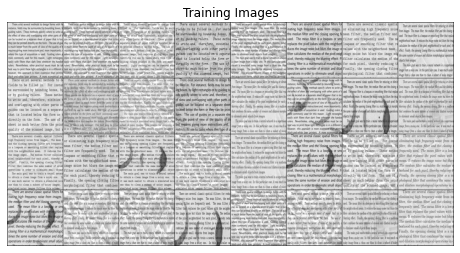

In [3]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.utils as vutils

dataroot = '/workspace/datasets/Kaggle'

image_size = 256
batch_size = 32
workers = 3

trans = A.Compose(
    [
        A.Resize(width = image_size, height = 256),
        A.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value = 255),
        ToTensorV2(),
    ],
    additional_targets={"image0":"image"}
)

dataset = DirtyCleanDataset(root_dirty = dataroot+'/train', root_clean = dataroot+'/train_cleaned',transform=trans)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True, num_workers = workers)

import matplotlib.pyplot as plt

real_batch = next(iter(dataloader))
# clean image
#plt.imshow(np.transpose(real_batch[1][30].cpu(),(1,2,0)))
# dirty image
#plt.imshow(np.transpose(real_batch[0][30].cpu(),(1,2,0)))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].cpu()[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
real_batch[0][30].shape

torch.Size([3, 256, 256])

In [5]:
# Build the model

import torch.nn as nn

loop = 5

class Discriminator(nn.Module):
    def __init__(self, input_channels, features_d):
        super(Discriminator,self).__init__()
        modules = []
        modules.append(nn.Conv2d(input_channels, features_d, kernel_size = 4, stride = 2, padding = 1))
        modules.append(nn.LeakyReLU(0.2))
        for i in range(loop):
            modules.append(self._conv(features_d * (2**i), features_d * (2**(i+1)),4,2,1))
        modules.append(nn.Conv2d(features_d * (2**loop), 1, kernel_size = 4, stride = 2, padding = 0))
        modules.append(nn.Sigmoid())
        self.disc = nn.Sequential(*modules)
    
    def _conv(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.LeakyReLU(0.2)
            )
    
    def forward(self, x):
        return self.disc(x)
    
    
class Generator(nn.Module):
    def __init__(self, input_channels, features_g):
        super(Generator, self).__init__()
        modules = []
        modules.append(self._dconv(input_channels,features_g,4,2,1))
        temp = features_g
        for i in range(loop):
            #modules.append(self._dconv(int(input_channels / (2**i)), int(features_g / (2**(i+1))),4,2,1))
            modules.append(self._dconv(temp, temp*2,4,2,1))
            temp = temp * 2
        for i in range(loop):
            #modules.append(self._uconv(input_channels * (2**i), features_g * (2**(i+1)),4,2,1))
            modules.append(self._uconv(int(temp), int(temp / 2),4,2,1))
            temp = temp/2
        modules.append(self._uconv(int(temp), input_channels,4,2,1))
        self.gen = nn.Sequential(*modules) 

        
    def _dconv(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2)
        )
    def _uconv(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2)
            )
    
    def forward(self,x):
        return self.gen(x)


# as for DCGAN    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            m.init.normal_(m.weight.data, 0.0, 0.02)
            
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
def test():
    N, in_channels, H, W = 8, 3, 256, 256
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    #print(disc(x).shape)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(in_channels, 8)
    z = torch.randn((N, in_channels, H, W))
    #print(gen(z).shape)
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


test()

In [6]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)
netG = Generator(input_channels = 3, features_g = 52).to(device)
netG.apply(weights_init)
summary(netG,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 52, 128, 128]           2,496
       BatchNorm2d-2         [-1, 52, 128, 128]             104
         LeakyReLU-3         [-1, 52, 128, 128]               0
            Conv2d-4          [-1, 104, 64, 64]          86,528
       BatchNorm2d-5          [-1, 104, 64, 64]             208
         LeakyReLU-6          [-1, 104, 64, 64]               0
            Conv2d-7          [-1, 208, 32, 32]         346,112
       BatchNorm2d-8          [-1, 208, 32, 32]             416
         LeakyReLU-9          [-1, 208, 32, 32]               0
           Conv2d-10          [-1, 416, 16, 16]       1,384,448
      BatchNorm2d-11          [-1, 416, 16, 16]             832
        LeakyReLU-12          [-1, 416, 16, 16]               0
           Conv2d-13            [-1, 832, 8, 8]       5,537,792
      BatchNorm2d-14            [-1, 83

In [7]:
netD = Discriminator(input_channels = 3, features_d = 52).to(device)
netD.apply(weights_init)
summary(netD,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 52, 128, 128]           2,548
         LeakyReLU-2         [-1, 52, 128, 128]               0
            Conv2d-3          [-1, 104, 64, 64]          86,528
       BatchNorm2d-4          [-1, 104, 64, 64]             208
              ReLU-5          [-1, 104, 64, 64]               0
         LeakyReLU-6          [-1, 104, 64, 64]               0
            Conv2d-7          [-1, 208, 32, 32]         346,112
       BatchNorm2d-8          [-1, 208, 32, 32]             416
              ReLU-9          [-1, 208, 32, 32]               0
        LeakyReLU-10          [-1, 208, 32, 32]               0
           Conv2d-11          [-1, 416, 16, 16]       1,384,448
      BatchNorm2d-12          [-1, 416, 16, 16]             832
             ReLU-13          [-1, 416, 16, 16]               0
        LeakyReLU-14          [-1, 416,

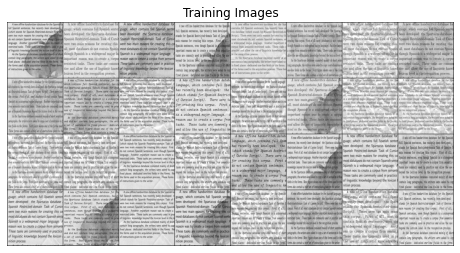

In [8]:
# read test image

Test = DirtyCleanDataset(root_dirty = dataroot+'/train', root_clean = dataroot+'/test',transform=trans)

Testloader = torch.utils.data.DataLoader(Test, batch_size=32, shuffle = True, num_workers = workers)

test_batch = next(iter(Testloader))


plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[1].cpu(), padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
# Train the model

from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Learning_rate = 1e-4
Channels_img = 3
Features_dis = 52
Feature_gen = 52
Num_epochs = 10
beta1 = 0.5

opt_netG = optim.Adam(netG.parameters(), lr = Learning_rate, betas = (beta1, 0.999))
opt_netD = optim.Adam(netD.parameters(), lr = Learning_rate, betas = (beta1, 0.999))

criterion = nn.BCEWithLogitsLoss()

writer_dirty = SummaryWriter(f"/workspace/practice/GAN/dirty")
writer_clean = SummaryWriter(f"/workspace/practice/GAN/clean")

G_losses = []
D_losses = []
img_list = []
iters = 0

print("Starting Train: ...")

for epoch in range(Num_epochs):
    for batch_idx, (dirty,clean) in enumerate(dataloader, 0):
        #Train Discriminator: maximize log(D(x)) + log(1-D(G(z)))
        netD.zero_grad()
        clean = clean.to(device)
        dirty = dirty.to(device)
        dirty_clean = netG(dirty)
        
        dis_clean = netD(clean).reshape(-1)
        loss_dis_clean = criterion(dis_clean, torch.ones_like(dis_clean))
        dis_dirty = netD(dirty_clean.detach()).reshape(-1)
        loss_dis_dirty = criterion(dis_dirty, torch.zeros_like(dis_dirty))
        loss_dis = (loss_dis_clean + loss_dis_dirty) / 2
        loss_dis.backward()
        opt_netD.step()
        
        #Train Generator: minimum log(1-D(G(z))) => maximize log(D(G(z)))
        netG.zero_grad()
        gen_clean = netG(dirty).reshape(-1)
        loss_gen = criterion(gen_clean, torch.ones_like(gen_clean))
        loss_gen.backward()
        opt_netG.step() 
        
        if batch_idx % 1 == 0:
            print(f"Epoch: [{epoch}/{Num_epochs}],  Batch: [{batch_idx}/{len(dataloader)}],  Loss_D: {loss_dis:.4f},  Loss_G: {loss_gen:.4f}")
            G_losses.append(loss_gen)
            D_losses.append(loss_dis)

            with torch.no_grad():
                fixedDirty = test_batch[1].to(device)
                dir2clean = netG(fixedDirty)
                
                img_dirty = torchvision.utils.make_grid(fixedDirty,normalize=True)
                img_clean = torchvision.utils.make_grid(dir2clean,normalize=True)
                
                writer_dirty.add_image("Dirty", img_dirty, global_step = iters) 
                writer_clean.add_image("Clean", img_clean, global_step = iters)
                
                
        iters += 1


Starting Train: ...
Epoch: [0/10],  Batch: [0/5],  Loss_D: 0.6672,  Loss_G: 0.5968
Epoch: [0/10],  Batch: [1/5],  Loss_D: 0.5420,  Loss_G: 0.5921
Epoch: [0/10],  Batch: [2/5],  Loss_D: 0.5491,  Loss_G: 0.5889
Epoch: [0/10],  Batch: [3/5],  Loss_D: 0.5034,  Loss_G: 0.5865
Epoch: [0/10],  Batch: [4/5],  Loss_D: 0.5040,  Loss_G: 0.5840
Epoch: [1/10],  Batch: [0/5],  Loss_D: 0.5039,  Loss_G: 0.5809
Epoch: [1/10],  Batch: [1/5],  Loss_D: 0.5032,  Loss_G: 0.5782
Epoch: [1/10],  Batch: [2/5],  Loss_D: 0.5032,  Loss_G: 0.5753
Epoch: [1/10],  Batch: [3/5],  Loss_D: 0.5032,  Loss_G: 0.5725
Epoch: [1/10],  Batch: [4/5],  Loss_D: 0.5032,  Loss_G: 0.5698
Epoch: [2/10],  Batch: [0/5],  Loss_D: 0.5032,  Loss_G: 0.5672
Epoch: [2/10],  Batch: [1/5],  Loss_D: 0.5032,  Loss_G: 0.5650
Epoch: [2/10],  Batch: [2/5],  Loss_D: 0.5032,  Loss_G: 0.5632
Epoch: [2/10],  Batch: [3/5],  Loss_D: 0.5032,  Loss_G: 0.5616
Epoch: [2/10],  Batch: [4/5],  Loss_D: 0.5032,  Loss_G: 0.5602
Epoch: [3/10],  Batch: [0/5],  Loss

In [10]:
torch.save(netD.state_dict(), './Discriminator.pth')
torch.save(netG.state_dict(), './Generator.pth')